# BUDT758T- Data Mining and Predictive Analytics

Fraud risk is everywhere, but for companies that advertise online, click fraud
can happen at an overwhelming volume, resulting in misleading click data and 
wasted money.

Ad channels can drive up costs by simply clicking on the ad at a large scale.
With over 1 billion smart mobile devices in active use every month, companies 
which invest large share into digital marketing therefore suffers from huge 
volumes of fraudulent traffic.

Preventive measures have the risk of losing potential customers 

The data is a subset   from  4 days click data of a company called Talking data. The data we used is of 1 day.

Data Source: https://www.kaggle.com/competitions/talkingdata-adtracking-fraud-detection/overview

# Import Libraries

In [ ]:
#Importing Required Libraries

import numpy as np
import pandas as pd
import gc
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# specifications for train
dtype = {'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint16',
    'click_id': 'uint32'}
train_columns = \
    ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']

In [ ]:
# Mounting google Drive to read file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading Data

In [ ]:
df = pd.read_csv(
    filepath_or_buffer='/content/drive/My Drive/Data Mining/November_7.csv',
    usecols=train_columns,
    dtype=dtype,
    parse_dates=['click_time'],
    infer_datetime_format=True)

# Feature Engineering & EDA

In [ ]:
df.describe()

,ip,app,device,os,channel,is_attributed
count,5.963331e+07,5.963331e+07,5.963331e+07,5.963331e+07,5.963331e+07,5.963331e+07
mean,8.646315e+04,1.250469e+01,3.746757e+01,2.557011e+01,2.687500e+02,2.551661e-03
std,5.786736e+04,1.604293e+01,3.335491e+02,6.715728e+01,1.293197e+02,5.044948e-02
min,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.037200e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.450000e+02,0.000000e+00
50%,7.992700e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.450000e+02,0.000000e+00
75%,1.194360e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.860000e+02,0.000000e+00
max,2.875400e+05,7.350000e+02,3.858000e+03,8.660000e+02,4.980000e+02,1.000000e+00


In [ ]:
df.isna().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

##### The dataset taken is has no null values and there is no need of Cleaning data# 

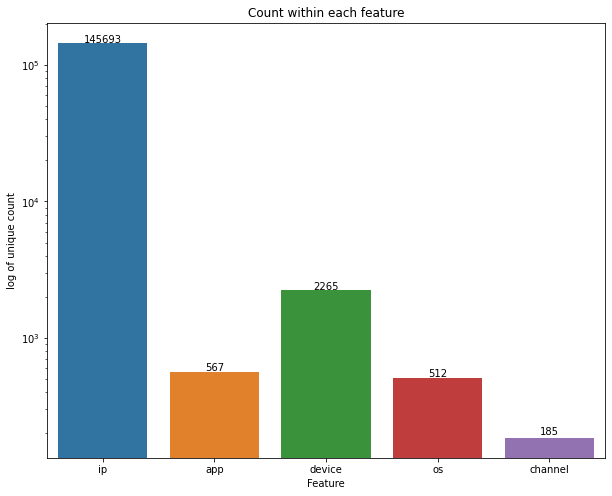

In [ ]:
col = ['ip','app','device','os','channel']
cnt = [len(df[i].unique()) for i in col]
plt.figure(figsize=(10,8))
ax=sns.barplot(x=col, y=cnt, log= True)
ax.set(xlabel='Feature', ylabel='log of unique count',title="Count within each feature")
for p, uni in zip(ax.patches, cnt):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 10,uni,ha="center")
plt.show()

#### Count of Each feature

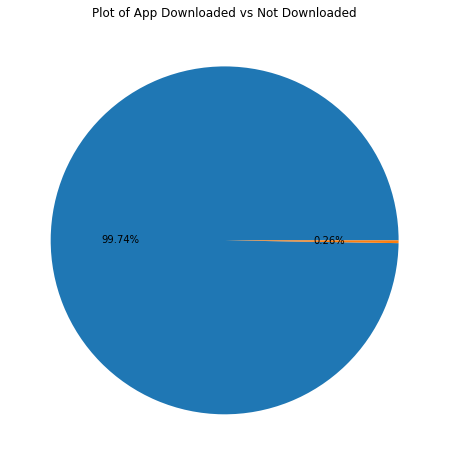

In [ ]:
plt.figure(figsize=(10,8))
plt.pie(df['is_attributed'].value_counts()*100,autopct='%1.2f%%')
plt.title("Plot of App Downloaded vs Not Downloaded")
plt.show()

#### Therefore, we can see the dataset is highly unbalanced

In [ ]:
    
# Type-casting click_time to date 
df['date'] = pd.to_datetime(df['click_time'])
    
# Extract features from date and time 
df['hour'] = df['date'].dt.hour.astype('uint8')
df['min'] = df['date'].dt.minute.astype('uint8')
df['sec'] = df['date'].dt.second.astype('uint8')
df['day'] = df['date'].dt.dayofweek.astype('uint16')
    
# Drop the original column
df.drop(['click_time'], axis= 1, inplace=True)
    
# Converting categorical features to type category 
cols = ['app', 'device', 'os', 'channel']
for col in cols:
  df[col] = df[col].astype('category')
        

In [ ]:
# Group by IP and count clicks per ip 
num_clicks_ip = df.groupby('ip').size().reset_index()
    
# naming the new column as 'clicks' 
num_clicks_ip = num_clicks_ip.rename(columns = {0:'clicks'})
    
# Append clicks column to data frame by meging on 'ip' 
df = pd.merge(df, num_clicks_ip, on = 'ip', how = 'left')
del num_clicks_ip

In [ ]:

# Group by IP and hour and count clicks per ip per hour 
num_clicks_ip = df.groupby(['ip','hour']).size().reset_index()
    
#  naming the new column as 'ip_hour_clicks' 
num_clicks_ip = num_clicks_ip.rename(columns = {0:'ip_hour_clicks'})
    
# Append clicks column to data frame by meging on 'ip' and 'hour' 
df = pd.merge(df, num_clicks_ip, on = ['ip','hour'], how = 'left')
del num_clicks_ip

In [ ]:
# downsampling the data having is_attributed==0 to make the whole dataset a balanced data set
df_downsampled = df[df['is_attributed'] == 0].sample(n=df[df.is_attributed == 1].shape[0], random_state = 6, replace = False)
    
# concatinating with ['is_attributed'] == 1 part and return fixed data
df = pd.concat([df_downsampled, df[df['is_attributed'] == 1]])
del df_downsampled

In [ ]:
df = df.sort_values('date')
    
# Obtain labels 
y = df['is_attributed'].values
    
# Drop unused columns and obtain features
cols = ['ip', 'is_attributed', 'date']
X = df.drop(columns = cols)
    

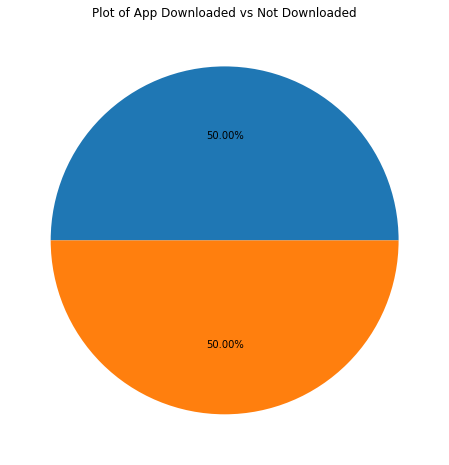

In [ ]:
plt.figure(figsize=(10,8))
plt.pie(df['is_attributed'].value_counts(normalize=True)*100,autopct='%1.2f%%')
plt.title("Plot of App Downloaded vs Not Downloaded")
plt.show()

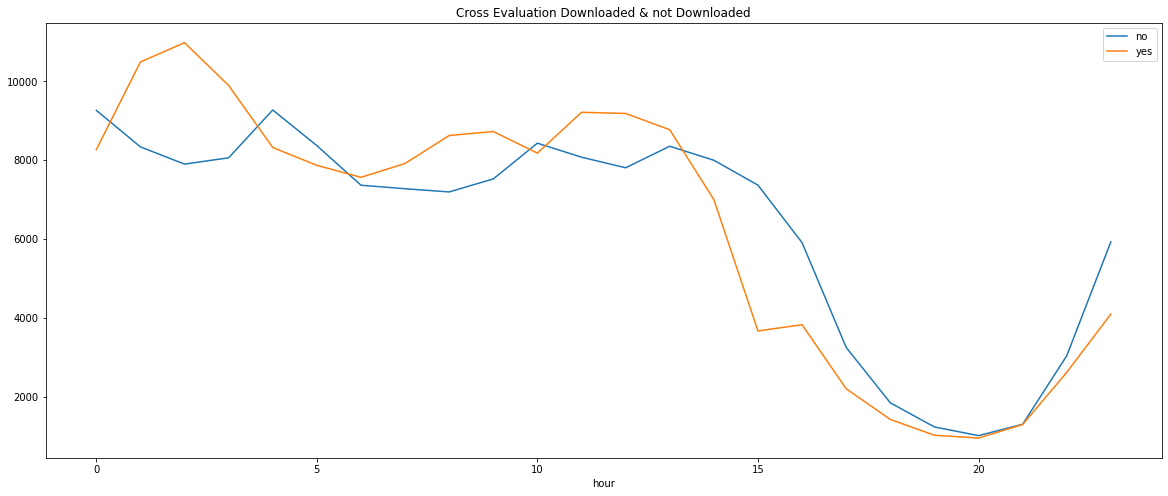

In [ ]:
dta_0=df[df['is_attributed']==0].groupby('hour')['app'].count()
dta_1=df[df['is_attributed']==1].groupby('hour')['app'].count()
plt.figure(figsize=(20,8))
dta_0.plot()
dta_1.plot()
plt.legend(["no","yes"])
plt.title("Cross Evaluation Downloaded & not Downloaded")
plt.show()

We can see that both the clicks that led to downloading the app and the clicks that didn't followed the same distribution.

In [ ]:
df.dtypes

ip                        uint32
app                     category
device                  category
os                      category
channel                 category
is_attributed             uint16
date              datetime64[ns]
hour                       uint8
min                        uint8
sec                        uint8
day                       uint16
clicks                     int64
ip_hour_clicks             int64
dtype: object

# Model Building and Validation

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=21)

## Decision Tree Classifer

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
DT = DecisionTreeClassifier()


DT.fit(X_train, y_train)
y_proba = DT.predict_proba(X_train)
y_val_proba = DT.predict_proba(X_val)

print(roc_auc_score(y_train, y_proba[:,1]) )
print(roc_auc_score(y_val, y_val_proba[:,1]))

0.9999999996963237
0.8907234782835725


#### Confusion Matrix for Decision Tree Classifier

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = DT.predict(X_train)
y_val_pred = DT.predict(X_val)
confusion_matrix(y_val, y_val_pred)

array([[26850,  3431],
       [ 3219, 27366]])

#### Accurcay score for Decision Tree Classifier

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

accuracy_score(y_val, y_val_pred)

0.8907436006966122

#### ROC curve for Decision Tree Classifier

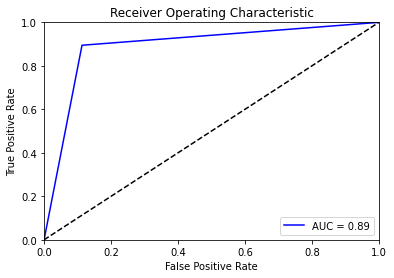

In [ ]:
fpr_DT, tpr_DT, threshold_DT = metrics.roc_curve(y_val, y_val_proba[:,1])
roc_auc_DT = metrics.auc(fpr_DT, tpr_DT)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_DT, tpr_DT, 'b', label = 'AUC = %0.2f' % roc_auc_DT)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
LR=LogisticRegression()

LR.fit(X,y)
y_proba = LR.predict_proba(X_train)
y_val_proba = LR.predict_proba(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### Confusion Matrix for Logistic Regression

In [ ]:
y_pred = LR.predict(X_train)
y_val_pred = LR.predict(X_val)
confusion_matrix(y_val, y_val_pred)

array([[21840,  8441],
       [ 8278, 22307]])

#### Accuracy score for Logistic Regression

In [ ]:
accuracy_score(y_val, y_val_pred)

0.7253146255709263

#### ROC curve for Logistic Regression

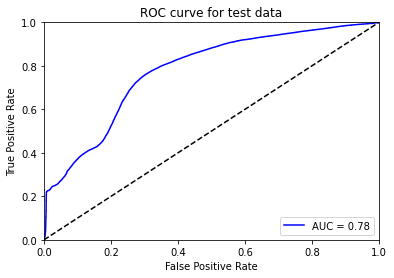

In [ ]:
fpr_LR, tpr_LR, threshold_LR = metrics.roc_curve(y_val, y_val_proba[:,1])
roc_auc_LR = metrics.auc(fpr_LR, tpr_LR)

plt.title('ROC curve for test data')
plt.plot(fpr_LR, tpr_LR, 'b', label = 'AUC = %0.2f' % roc_auc_LR)
#plt.plot(fpr_DT, tpr_DT, 'b', label = 'AUC = %0.2f' % roc_auc,color='black')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Naive Bayes 

In [ ]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X,y)
y_proba = NB.predict_proba(X_train)
y_val_proba = NB.predict_proba(X_val)

#### Confusion Matrix fo Naive Bayes

In [ ]:
y_pred = NB.predict(X_train)
y_val_pred = NB.predict(X_val)
confusion_matrix(y_val, y_val_pred)

array([[11910, 18371],
       [ 4949, 25636]])

#### Accuracy score for Naive Bayes

In [ ]:
accuracy_score(y_val, y_val_pred)

0.6168632734203003

#### ROC curve for Naive Bayes

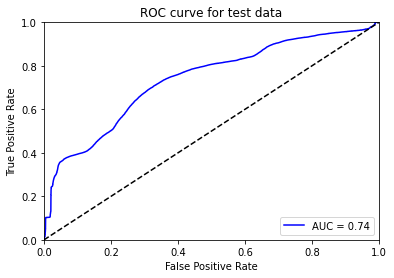

In [ ]:
fpr_NB, tpr_NB, threshold_NB = metrics.roc_curve(y_val, y_val_proba[:,1])
roc_auc_NB = metrics.auc(fpr_NB, tpr_NB)

plt.title('ROC curve for test data')
plt.plot(fpr_NB, tpr_NB, 'b', label = 'AUC = %0.2f' % roc_auc_NB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## K-Nearest Neighbour

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
scores_list = []
range_k = range(1,15)
for k in range_k:
   KNN = KNeighborsClassifier(n_neighbors=k)
   KNN.fit(X_train, y_train)
   y_pred = KNN.predict(X_val)
   scores_list.append(accuracy_score(y_val,y_pred))


Confusion Matrix:
[[28486  1795]
 [ 6146 24439]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88     30281
           1       0.93      0.80      0.86     30585

    accuracy                           0.87     60866
   macro avg       0.88      0.87      0.87     60866
weighted avg       0.88      0.87      0.87     60866



#### Hyper Parameter Tuning for K-NN

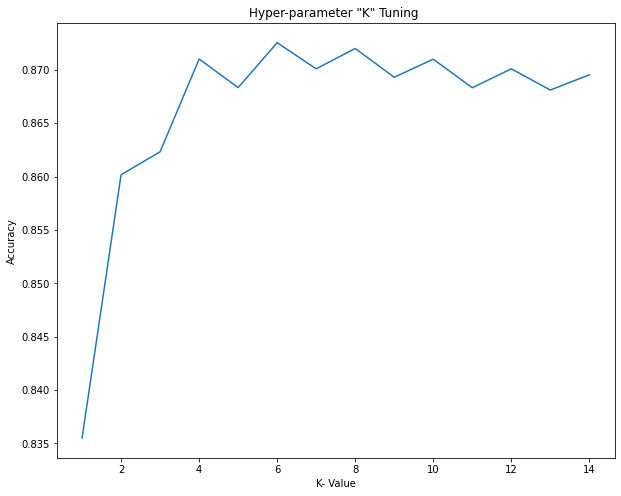

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(range_k,scores_list)
plt.ylabel('Accuracy')
plt.xlabel('K- Value')
plt.title('Hyper-parameter "K" Tuning ')
plt.show()

In [ ]:
max(scores_list)

0.8725396773239575

In [ ]:
n=range_k[np.argmax(scores_list)]
n

6

#### Accuracy for K-NN for the best 'n'

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=n)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)
accuracy_score(y_val,y_pred)
result = metrics.confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(result)
result1 = metrics.classification_report(y_val, y_pred)
print("Classification Report:",)
print (result1)

Confusion Matrix:
[[28546  1735]
 [ 6023 24562]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     30281
           1       0.93      0.80      0.86     30585

    accuracy                           0.87     60866
   macro avg       0.88      0.87      0.87     60866
weighted avg       0.88      0.87      0.87     60866



#### Confusion Matrix for K-NN

In [ ]:
metrics.confusion_matrix(y_val, y_pred)

array([[28546,  1735],
       [ 6023, 24562]])

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
scores_list = []
range_k = range(1,25)
for k in range_k:
  RF = RandomForestClassifier(max_depth=k)
  RF.fit(X_train, y_train)
  y_proba = RF.predict_proba(X_train)
  y_val_proba = RF.predict_proba(X_val)
  y_pred = RF.predict(X_val)
  scores_list.append(accuracy_score(y_val,y_pred))



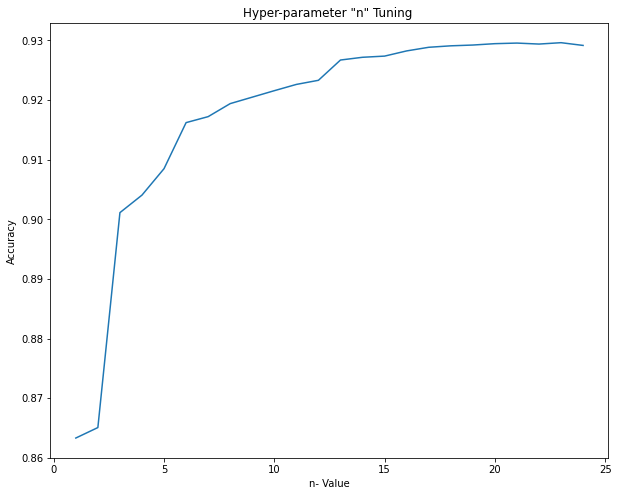

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(range_k,scores_list)
plt.ylabel('Accuracy')
plt.xlabel('n- Value')
plt.title('Hyper-parameter "n" Tuning ')
plt.show()

In [ ]:
n=range_k[np.argmax(scores_list)]
n

23

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(max_depth=n)
RF.fit(X_train, y_train)
y_proba = RF.predict_proba(X_train)
y_val_proba = RF.predict_proba(X_val)

print(roc_auc_score(y_train, y_proba[:,1]) )
print(roc_auc_score(y_val, y_val_proba[:,1]))

0.9983573282037139
0.973249105721774


#### Confusion Matrix for Random Forest Classifier

In [ ]:
y_pred = RF.predict(X_train)
y_val_pred = RF.predict(X_val)
confusion_matrix(y_val, y_val_pred)

array([[29229,  1091],
       [ 3223, 27323]])

#### Accuracy score for Random Forest Classifier

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_val_pred)

0.9291229914895015

#### ROC Curve for Random Forest classifier

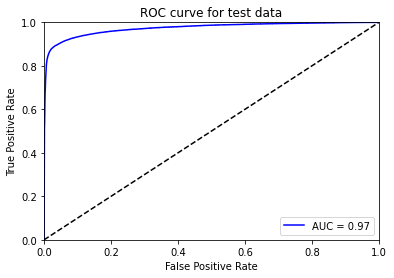

In [ ]:
fpr_RF, tpr_RF, threshold_RF = metrics.roc_curve(y_val, y_val_proba[:,1])
roc_auc_RF = metrics.auc(fpr_RF, tpr_RF)

plt.title('ROC curve for test data')
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC = %0.2f' % roc_auc_RF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn import tree
text_representation = tree.export_text(RF.estimators_[0])
print(text_representation)

|--- feature_9 <= -0.19
|   |--- feature_2 <= -0.07
|   |   |--- feature_9 <= -0.19
|   |   |   |--- feature_0 <= -0.10
|   |   |   |   |--- feature_2 <= -0.21
|   |   |   |   |   |--- feature_8 <= -0.22
|   |   |   |   |   |   |--- feature_3 <= -0.95
|   |   |   |   |   |   |   |--- feature_5 <= 0.24
|   |   |   |   |   |   |   |   |--- feature_5 <= 0.07
|   |   |   |   |   |   |   |   |   |--- feature_8 <= -0.22
|   |   |   |   |   |   |   |   |   |   |--- feature_0 <= -0.18
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- feature_0 >  -0.18
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- feature_8 >  -0.22
|   |   |   |   |   |   |   |   |   |   |--- feature_9 <= -0.20
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_9 >  -0.20
|   |   |   |   |   |   |   |   |  

## AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
AD = AdaBoostClassifier()

AD.fit(X_train, y_train)
y_proba = AD.predict_proba(X_train)
y_val_proba = AD.predict_proba(X_val)

print(roc_auc_score(y_train, y_proba[:,1]) )
print(roc_auc_score(y_val, y_val_proba[:,1]))

0.9638578951617272
0.9640074765261684


##### Confusion Matrix for Adaboost classifier

In [ ]:
y_pred = AD.predict(X_train)
y_val_pred = AD.predict(X_val)
confusion_matrix(y_val, y_val_pred)

array([[29264,  1056],
       [ 4020, 26526]])

#### Accuracy score for Adaboost Classifier

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_val_pred)

0.9166036867873689

#### ROC curve for Adaboost Classifier

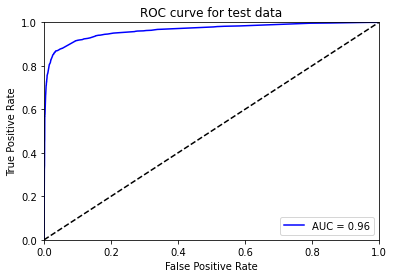

In [ ]:
fpr_AD, tpr_AD, threshold_AD = metrics.roc_curve(y_val, y_val_proba[:,1])
roc_auc_AD = metrics.auc(fpr_AD, tpr_AD)

plt.title('ROC curve for test data')
plt.plot(fpr_AD, tpr_AD, 'b', label = 'AUC = %0.2f' % roc_auc_AD)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Binary Neural Network Binary Classifier

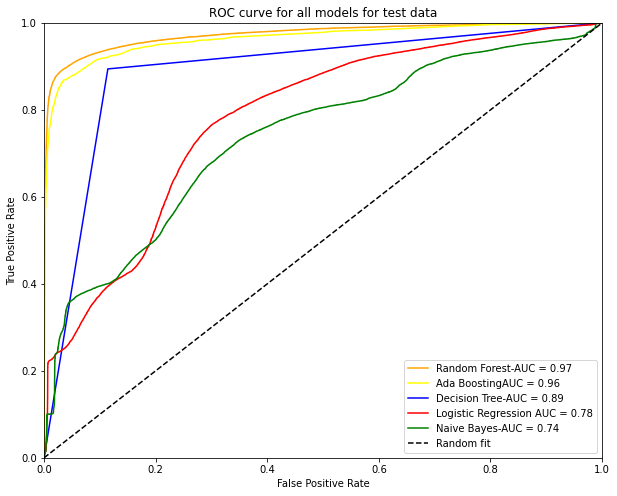

In [ ]:
plt.figure(figsize=(10,8))
plt.title('ROC curve for all models for test data')


plt.plot(fpr_RF, tpr_RF, color='orange', label = 'AUC = %0.2f' % roc_auc_RF)
plt.plot(fpr_AD, tpr_AD, color='yellow', label = 'AUC = %0.2f' % roc_auc_AD)
plt.plot(fpr_DT, tpr_DT, 'b', label = 'AUC = %0.2f' % roc_auc_DT)
plt.plot(fpr_LR, tpr_LR, 'r', label = 'AUC = %0.2f' % roc_auc_LR)
plt.plot(fpr_NB, tpr_NB, 'g', label = 'AUC = %0.2f' % roc_auc_NB)


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.legend(['Random Forest-AUC = %0.2f' % roc_auc_RF,'Ada BoostingAUC = %0.2f' % roc_auc_AD,'Decision Tree-AUC = %0.2f' % roc_auc_DT,'Logistic Regression AUC = %0.2f' % roc_auc_LR,'Naive Bayes-AUC = %0.2f' % roc_auc_NB, 'Random fit'])

#plt.legend(['Decision Tree-AUC = %0.2f' % roc_auc_RF,'Logistic Regression AUC = %0.2f' % roc_auc_LR,'Naive Bayes-AUC = %0.2f' % roc_auc_NB, 'Random Forest-AUC = %0.2f' % roc_auc_RF,'Ada BoostingAUC = %0.2f' % roc_auc_AD,'Random fit'])
#plt.legend(['Naive Bayes-AUC = %0.2f' % roc_auc_NB,'Logistic Regression AUC = %0.2f' % roc_auc_LR,'Ada BoostingAUC = %0.2f' % roc_auc_AD,'Decision Tree-AUC = %0.2f' % roc_auc_RF, 'Random Forest-AUC = %0.2f' % roc_auc_RF,'Random fit'])

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Binary Neural Network Binary Classifier

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
def create_baseline():
  model = Sequential()
  model.add(Dense(256, input_dim=10, activation='relu'))
  model.add(Dense(256, activation='LeakyReLU'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='LeakyReLU'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='LeakyReLU'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

##### Confusion Matrix for Binary Neural Network Binary Classifier

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=400, batch_size=15250, verbose=0)))
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_val_pred = pipeline.predict(X_val)
confusion_matrix(y_val, y_val_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  import sys


array([[29047,  1273],
       [ 3477, 27069]])

#### Accuracy score for Binary Neural Network Binary Classifier

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_val_pred)

0.9219597147832944